##### Copyright 2023 The TF-Agents Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train a Deep Q Network with TF-Agents

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/agents/docs/tutorials/1_dqn_tutorial.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Introduction


This example shows how to train a [DQN (Deep Q Networks)](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)  agent on the Cartpole environment using the TF-Agents library.

![Cartpole environment](https://raw.githubusercontent.com/tensorflow/agents/master/docs/tutorials/images/cartpole.png)

It will walk you through all the components in a Reinforcement Learning (RL) pipeline for training, evaluation and data collection.


To run this code live, click the 'Run in Google Colab' link above.


## Setup

If you haven't installed the following dependencies, run:

In [2]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease     
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease   
Hit:5 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease    
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Hit:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease                
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease              
Hit:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Fetched 129 kB in 1s (106 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to prov

In [3]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

2025-11-16 22:17:31.628553: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-16 22:17:31.628611: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-16 22:17:31.630300: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/r

In [4]:
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [5]:
tf.version.VERSION

'2.15.1'

## Hyperparameters

In [6]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

## Environment

In Reinforcement Learning (RL), an environment represents the task or problem to be solved. Standard environments can be created in TF-Agents using `tf_agents.environments` suites. TF-Agents has suites for loading environments from sources such as the OpenAI Gym, Atari, and DM Control.

Load the CartPole environment from the OpenAI Gym suite. 

In [7]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)

You can render this environment to see how it looks. A free-swinging pole is attached to a cart.  The goal is to move the cart right or left in order to keep the pole pointing up.

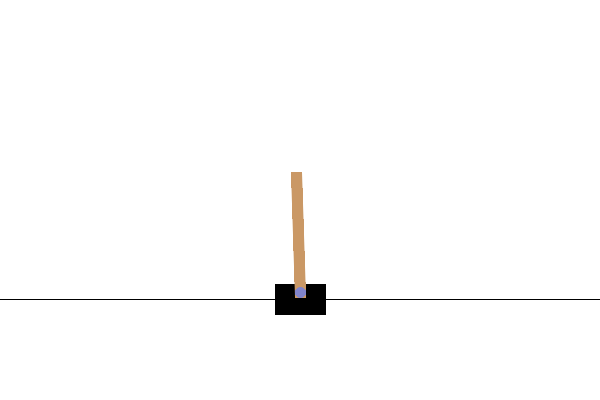

In [8]:
#@test {"skip": true}
env.reset()
PIL.Image.fromarray(env.render())

The `environment.step` method takes an `action` in the environment and returns a `TimeStep` tuple containing the next observation of the environment and the reward for the action.

The `time_step_spec()` method returns the specification for the `TimeStep` tuple. Its `observation` attribute shows the shape of observations, the data types, and the ranges of allowed values. The `reward` attribute shows the same details for the reward.


In [9]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])


In [10]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


The `action_spec()` method returns the shape, data types, and allowed values of valid actions.

In [11]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In the Cartpole environment:

-   `observation` is an array of 4 floats: 
    -   the position and velocity of the cart
    -   the angular position and velocity of the pole 
-   `reward` is a scalar float value
-   `action` is a scalar integer with only two possible values:
    -   `0` — "move left"
    -   `1` — "move right"


In [12]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'step_type': array(0, dtype=int32),
 'reward': array(0., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([ 0.03731187,  0.02798141,  0.01874731, -0.03541209], dtype=float32)})
Next time step:
TimeStep(
{'step_type': array(1, dtype=int32),
 'reward': array(1., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([ 0.0378715 ,  0.22282957,  0.01803907, -0.3221216 ], dtype=float32)})


Usually two environments are instantiated: one for training and one for evaluation. 

In [13]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

The Cartpole environment, like most environments, is written in pure Python. This is converted to TensorFlow using the `TFPyEnvironment` wrapper.

The original environment's API uses Numpy arrays. The `TFPyEnvironment` converts these to `Tensors` to make it compatible with Tensorflow agents and policies.


In [14]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agent

The algorithm used to solve an RL problem is represented by an `Agent`. TF-Agents provides standard implementations of a variety of `Agents`, including:

-   [DQN](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) (used in this tutorial)
-   [REINFORCE](https://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)
-   [DDPG](https://arxiv.org/pdf/1509.02971.pdf)
-   [TD3](https://arxiv.org/pdf/1802.09477.pdf)
-   [PPO](https://arxiv.org/abs/1707.06347)
-   [SAC](https://arxiv.org/abs/1801.01290)

The DQN agent can be used in any environment which has a discrete action space.

At the heart of a DQN Agent is a `QNetwork`, a neural network model that can learn to predict `QValues` (expected returns) for all actions, given an observation from the environment.

We will use `tf_agents.networks.` to create a `QNetwork`. The network will consist of a sequence of `tf.keras.layers.Dense` layers, where the final layer will have 1 output for each possible action.

In [15]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

Now use `tf_agents.agents.dqn.dqn_agent` to instantiate a `DqnAgent`. In addition to the `time_step_spec`, `action_spec` and the QNetwork, the agent constructor also requires an optimizer (in this case, `AdamOptimizer`), a loss function, and an integer step counter.

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

## Policies

A policy defines the way an agent acts in an environment. Typically, the goal of reinforcement learning is to train the underlying model until the policy produces the desired outcome.

In this tutorial:

-   The desired outcome is keeping the pole balanced upright over the cart.
-   The policy returns an action (left or right) for each `time_step` observation.

Agents contain two policies: 

-   `agent.policy` — The main policy that is used for evaluation and deployment.
-   `agent.collect_policy` — A second policy that is used for data collection.


In [17]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

Policies can be created independently of agents. For example, use `tf_agents.policies.random_tf_policy` to create a policy which will randomly select an action for each `time_step`.

In [18]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

To get an action from a policy, call the `policy.action(time_step)` method. The `time_step` contains the observation from the environment. This method returns a `PolicyStep`, which is a named tuple with three components:

-   `action` — the action to be taken (in this case, `0` or `1`)
-   `state` — used for stateful (that is, RNN-based) policies
-   `info` — auxiliary data, such as log probabilities of actions

In [19]:
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load('CartPole-v0'))

In [20]:
time_step = example_environment.reset()

In [21]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>, state=(), info=())

## Metrics and Evaluation

The most common metric used to evaluate a policy is the average return. The return is the sum of rewards obtained while running a policy in an environment for an episode. Several episodes are run, creating an average return.

The following function computes the average return of a policy, given the policy, environment, and a number of episodes.


In [22]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

Running this computation on the `random_policy` shows a baseline performance in the environment.

In [23]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

21.4

## Replay Buffer

In order to keep track of the data collected from the environment, we will use [Reverb](https://deepmind.com/research/open-source/Reverb), an efficient, extensible, and easy-to-use replay system by Deepmind. It stores experience data when we collect trajectories and is consumed during training.

This replay buffer is constructed using specs describing the tensors that are to be stored, which can be obtained from the agent using agent.collect_data_spec.


In [24]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpci5i94bh.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmpci5i94bh
[reverb/cc/platform/default/server.cc:71] Started replay server on port 36875


For most agents, `collect_data_spec` is a named tuple called `Trajectory`, containing the specs for observations, actions, rewards, and other items.

In [25]:
agent.collect_data_spec

Trajectory(
{'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)),
 'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)),
 'policy_info': (),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32))})

In [26]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

## Data Collection

Now execute the random policy in the environment for a few steps, recording the data in the replay buffer.

Here we are using 'PyDriver' to run the experience collecting loop. You can learn more about TF Agents driver in our [drivers tutorial](https://www.tensorflow.org/agents/tutorials/4_drivers_tutorial).

In [27]:
#@test {"skip": true}
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'step_type': array(1, dtype=int32),
  'reward': array(1., dtype=float32),
  'discount': array(1., dtype=float32),
  'observation': array([-0.05670064, -0.3523089 ,  0.01715042,  0.5957191 ], dtype=float32)}),
 ())

The replay buffer is now a collection of Trajectories.

In [28]:
# For the curious:
# Uncomment to peel one of these off and inspect it.
# iter(replay_buffer.as_dataset()).next()

The agent needs access to the replay buffer. This is provided by creating an iterable `tf.data.Dataset` pipeline which will feed data to the agent.

Each row of the replay buffer only stores a single observation step. But since the DQN Agent needs both the current and next observation to compute the loss, the dataset pipeline will sample two adjacent rows for each item in the batch (`num_steps=2`).

This dataset is also optimized by running parallel calls and prefetching data.

In [29]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

<_PrefetchDataset element_spec=(Trajectory(
{'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 4), dtype=tf.float32, name=None),
 'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'policy_info': (),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)))>

In [30]:
iterator = iter(dataset)
print(iterator)

In [31]:
# For the curious:
# Uncomment to see what the dataset iterator is feeding to the agent.
# Compare this representation of replay data 
# to the collection of individual trajectories shown earlier.

# iterator.next()

## Training the agent

Two things must happen during the training loop:

-   collect data from the environment
-   use that data to train the agent's neural network(s)

This example also periodicially evaluates the policy and prints the current score.

The following will take ~5 minutes to run.

In [32]:
#@test {"skip": true}
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (1955) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (1955) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (1955) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (1955) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (1955) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (1955) so Table uniform_table is accessed directly without gRPC.


step = 200: loss = 70.1094970703125
step = 400: loss = 3.798314094543457
step = 600: loss = 3.774958610534668
step = 800: loss = 19.087535858154297
step = 1000: loss = 7.439586162567139
step = 1000: Average Return = 44.20000076293945
step = 1200: loss = 19.62786865234375
step = 1400: loss = 239.8076629638672
step = 1600: loss = 30.27637481689453
step = 1800: loss = 52.74143981933594
step = 2000: loss = 146.55799865722656
step = 2000: Average Return = 200.0
step = 2200: loss = 96.14210510253906
step = 2400: loss = 445.6754455566406
step = 2600: loss = 2525.466796875
step = 2800: loss = 640.9675903320312
step = 3000: loss = 795.6626586914062
step = 3000: Average Return = 180.6999969482422
step = 3200: loss = 171.37899780273438
step = 3400: loss = 2786.335693359375
step = 3600: loss = 1397.821533203125
step = 3800: loss = 1245.7100830078125
step = 4000: loss = 3231.29345703125
step = 4000: Average Return = 200.0
step = 4200: loss = 1427.152587890625
step = 4400: loss = 197.14068603515625


## Visualization


### Plots

Use `matplotlib.pyplot` to chart how the policy improved during training.

One iteration of `Cartpole-v0` consists of 200 time steps. The environment gives a reward of `+1` for each step the pole stays up, so the maximum return for one episode is 200. The charts shows the return increasing towards that maximum each time it is evaluated during training. (It may be a little unstable and not increase monotonically each time.)

(-0.1300004005432136, 250.0)

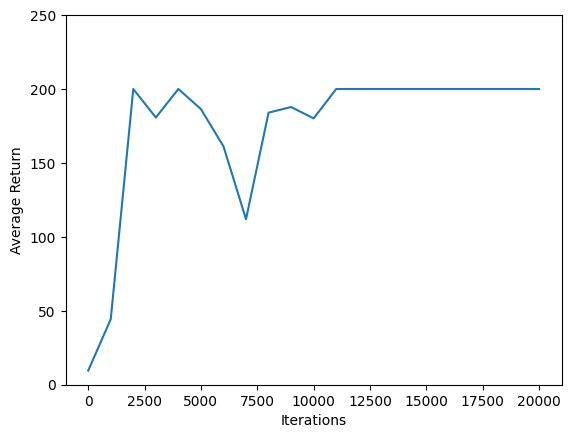

In [33]:
#@test {"skip": true}

iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

### Videos

Charts are nice. But more exciting is seeing an agent actually performing a task in an environment. 

First, create a function to embed videos in the notebook.

In [34]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

Now iterate through a few episodes of the Cartpole game with the agent. The underlying Python environment (the one "inside" the TensorFlow environment wrapper) provides a `render()` method, which outputs an image of the environment state. These can be collected into a video.

In [35]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")

[swscaler @ 0x573b3f772a00] Warning: data is not aligned! This can lead to a speed loss


For fun, compare the trained agent (above) to an agent moving randomly. (It does not do as well.)

In [36]:
create_policy_eval_video(random_policy, "random-agent")

[swscaler @ 0x5ca574e20a00] Warning: data is not aligned! This can lead to a speed loss


In [40]:
# ================================
#  PARTE 1 - CONFIGURACIÓN INICIAL
# ================================

# Comprobar GPU
import tensorflow as tf
print("TensorFlow:", tf.__version__)
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

# Asegurarnos de que gym 0.23.1 funciona (compatible con tf-agents)
import gym
print("Gym versión:", gym.__version__)

# Cargar un entorno simple
env = gym.make("CartPole-v1")

# Probar una interacción
state = env.reset()
print("Estado inicial:", state)

action = env.action_space.sample()
next_state, reward, done, info = env.step(action)

print("Acción aleatoria:", action)
print("Siguiente estado:", next_state)
print("Recompensa:", reward)
print("¿Terminado?:", done)

env.close()
print("✔️ ENTORNO LISTO Y FUNCIONANDO")


TensorFlow: 2.15.1
GPU disponible: []
Gym versión: 0.23.0
Estado inicial: [-0.03885391 -0.03849127 -0.04093884 -0.01342356]
Acción aleatoria: 1
Siguiente estado: [-0.03962373  0.15719315 -0.04120731 -0.3187369 ]
Recompensa: 1.0
¿Terminado?: False
✔️ ENTORNO LISTO Y FUNCIONANDO


In [73]:
import tensorflow as tf
import numpy as np
import gym
import imageio

from tf_agents.environments import suite_gym, tf_py_environment
from tf_agents.networks.q_network import QNetwork
from tf_agents.agents.dqn.dqn_agent import DqnAgent
from tf_agents.policies import greedy_policy
from tf_agents.utils import common
from tf_agents.trajectories import time_step as ts  # <--- importante


In [56]:
import gym
from tf_agents.environments import suite_gym, tf_py_environment

# -------------------------------
# Entorno MountainCar
# -------------------------------
env_name = "MountainCar-v0"

# Entorno Gym
py_env = gym.make(env_name)
state = py_env.reset()
print("Estado inicial MountainCar:", state)

# Envolver en TF-Agents
tf_env = tf_py_environment.TFPyEnvironment(suite_gym.wrap_env(py_env))

print("Observación (TF spec):", tf_env.observation_spec())
print("Acción (TF spec):", tf_env.action_spec())


Estado inicial MountainCar: [-0.40990153  0.        ]
Observación (TF spec): BoundedTensorSpec(shape=(2,), dtype=tf.float32, name='observation', minimum=array([-1.2 , -0.07], dtype=float32), maximum=array([0.6 , 0.07], dtype=float32))
Acción (TF spec): BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(2))


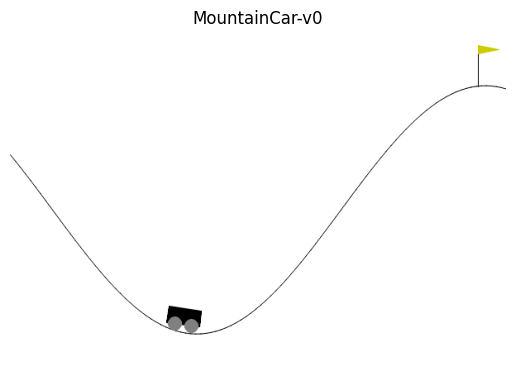

In [57]:
import matplotlib.pyplot as plt

# Reiniciamos el entorno
state = py_env.reset()

# Capturamos un frame (imagen) del entorno
frame = py_env.render(mode="rgb_array")

# Mostrar el frame con matplotlib
plt.imshow(frame)
plt.axis('off')
plt.title("MountainCar-v0")
plt.show()

# Cerramos el entorno al final
py_env.close()


In [60]:
import gym
import imageio

env = gym.make("MountainCar-v0")
frames = []

state = env.reset()
done = False

while not done:
    action = env.action_space.sample()  # acción aleatoria
    state, reward, done, info = env.step(action)
    frame = env.render(mode="rgb_array")  # devuelve imagen, no abre ventana
    frames.append(frame)

env.close()

# Guardar video
imageio.mimsave("mountaincar_random.mp4", frames, fps=30)


[swscaler @ 0x55e0cfb4ea00] Warning: data is not aligned! This can lead to a speed loss


In [61]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open("mountaincar_random.mp4","rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f'<video width=600 controls><source src="{data_url}" type="video/mp4"></video>')


In [63]:
# ================================
# PARTE 3 - CREAR Q-NETWORK Y DQN AGENT
# ================================

from tf_agents.networks.q_network import QNetwork
from tf_agents.agents.dqn.dqn_agent import DqnAgent
from tf_agents.utils import common

# Parámetros de entrenamiento
fc_layer_params = (128, 128)  # Capas totalmente conectadas

# Crear Q-Network
q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    fc_layer_params=fc_layer_params
)

# Crear optimizador
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Crear agente DQN
agent = DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    epsilon_greedy=0.1,  # exploración
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=tf.Variable(0)
)

agent.initialize()
print("✔️ DQN Agent creado y listo")


✔️ DQN Agent creado y listo


In [64]:
# ================================
# PARTE 4 - ENTRENAMIENTO DEL AGENTE
# ================================

from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

# Parámetros de entrenamiento
num_iterations = 5000      # Número de pasos de entrenamiento
collect_steps_per_iteration = 1
replay_buffer_max_length = 10000
batch_size = 64

# Crear Replay Buffer
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_max_length
)

# Función para recolectar un paso y almacenar en buffer
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    buffer.add_batch(traj)

# Inicializar recolección de datos
for _ in range(100):  # pasos aleatorios iniciales
    collect_step(tf_env, agent.policy, replay_buffer)

# Dataset de entrenamiento
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2
).prefetch(3)

iterator = iter(dataset)

# Entrenamiento principal
for i in range(num_iterations):
    collect_step(tf_env, agent.policy, replay_buffer)
    experience, _ = next(iterator)
    train_loss = agent.train(experience).loss

    if i % 500 == 0:
        print(f"Paso {i}: pérdida = {train_loss:.4f}")

print("✔️ Entrenamiento completado")


Paso 0: pérdida = 0.9999
Paso 500: pérdida = 3.4169
Paso 1000: pérdida = 4.5095
Paso 1500: pérdida = 3.0649
Paso 2000: pérdida = 2.4786
Paso 2500: pérdida = 2.2229
Paso 3000: pérdida = 46.3908
Paso 3500: pérdida = 2.4667
Paso 4000: pérdida = 1.2526
Paso 4500: pérdida = 230.1076
✔️ Entrenamiento completado


In [70]:
import tensorflow as tf
from tf_agents.trajectories.time_step import StepType, TimeStep

def gym_to_time_step(observation, reward=0.0, done=False):
    """
    Convierte la observación de Gym a TimeStep para TF-Agents
    """
    observation = np.expand_dims(observation, axis=0)  # <-- agrega la dimensión del batch
    step_type = StepType.LAST if done else StepType.MID
    discount = 0.0 if done else 1.0
    return TimeStep(
        step_type=tf.convert_to_tensor([step_type], dtype=tf.int32),
        reward=tf.convert_to_tensor([reward], dtype=tf.float32),
        discount=tf.convert_to_tensor([discount], dtype=tf.float32),
        observation=tf.convert_to_tensor(observation, dtype=tf.float32)
    )


In [71]:
frames = []
state = py_env.reset()
done = False

while not done:
    time_step = gym_to_time_step(state)
    action_step = agent.policy.action(time_step)
    action = int(action_step.action.numpy()[0])

    state, reward, done, info = py_env.step(action)
    
    frame = py_env.render(mode="rgb_array")
    frames.append(frame)


In [74]:
import numpy as np
import imageio

# Función para ejecutar un episodio y capturar frames
def run_episode_and_capture(policy, env, max_steps=200):
    frames = []
    state = env.reset()
    done = False
    step_count = 0

    while not done and step_count < max_steps:
        # Convertir observación de Gym a TimeStep para TF-Agents
        observation = np.expand_dims(state, axis=0)  # añade dimensión batch
        time_step = ts.TimeStep(
    step_type=tf.convert_to_tensor([0], dtype=tf.int32),
    reward=tf.convert_to_tensor([0.0], dtype=tf.float32),
    discount=tf.convert_to_tensor([1.0], dtype=tf.float32),
    observation=tf.convert_to_tensor(observation, dtype=tf.float32)

        )

        # Acción según la política entrenada
        action_step = policy.action(time_step)
        action = int(action_step.action.numpy()[0])

        # Ejecutar acción en el entorno
        state, reward, done, info = env.step(action)

        # Capturar frame
        frame = env.render(mode="rgb_array")
        frames.append(frame)

        step_count += 1

    return frames

# Ejecutar un episodio
frames = run_episode_and_capture(agent.policy, py_env)

# Guardar video
video_path = "/kaggle/working/mountaincar_dqn.mp4"
imageio.mimsave(video_path, frames, fps=30)
print("🎬 Video guardado en:", video_path)


[swscaler @ 0x56e7761b3a00] Warning: data is not aligned! This can lead to a speed loss


🎬 Video guardado en: /kaggle/working/mountaincar_dqn.mp4


In [76]:
from IPython.display import HTML
from base64 import b64encode

def show_video(path):
    video_file = open(path, "rb").read()
    video_base64 = b64encode(video_file).decode("ascii")
    return HTML(f"""
    <video width="640" height="480" controls autoplay loop>
        <source src="data:video/mp4;base64,{video_base64}" type="video/mp4">
    </video>
    """)

# Mostrar el video
show_video("/kaggle/working/mountaincar_dqn.mp4")
